In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
transf=tr.Compose([tr.Resize(16),tr.ToTensor()]) #원하는 전처리 넣기, 16X16이미지 크기 변환
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transf) #클래스가 10개인 이미지 세트, root=다운받을 경로,
testset=torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transf) #미리 선언한 전처리 사용하기
print(trainset[0][0].size())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 16, 16])


In [ ]:
trainloader=DataLoader(trainset,batch_size=50,shuffle=True) #DataLoader:데이터를 미니배치형태로
testlodaer=DataLoader(testset,batch_size=50,shuffle=False) #무작위 데이터 섞지않고 한번에 50개이미지 묶은 배치 제공
len(trainloader) #CIFAR10의 학습 이미지는 50000장, 배치사이즈 50장이므로 1000은 배치의 개수

1000

In [ ]:
images,labels=iter(trainloader).next()
print(images.size()) #iter,next 함수 이용해서 trainloader의 첫번째 배치 불러오기

torch.Size([50, 3, 16, 16])


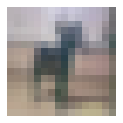

In [ ]:
oneshot=images[1].permute(1,2,0).numpy() #permute(1,2,0)은 기존 차원의 위치 0,1,2를 1,2,0로 바꿔줌(3,16,16)->(16,16,3)
plt.figure(figsize=(2,2))
plt.imshow(oneshot)
plt.axis("off")
plt.show()

In [ ]:
# transf=tr.Compose([tr.Resize(128),tr.ToTensor()])
# trainset=torchvision.datasets.ImageFolder(root='./class', transform=transf)
# trainloader=DataLoader(trainset,batch_size=1,shuffle=False)

TypeError: ignored

4.3.4 커스텀 데이터와 커스텀 전처리 사용하기
파이토치는 전처리 함수들을 제공
하지만 이미지의 경우 PILImage, Tensor 타입일 때 사용가능.
전처리 클래스 2개를 직접 정의해보자!

In [ ]:
#입력 데이터를 텐서 데이터로 변환해 주고 학습에 맞는 크기로 변환하는 작업
class ToTensor: 
  def __call__(self,sample):
    inputs, labels=sample
    inputs=torch.FloatTensor(inputs)
    inputs=inputs.permute(2,0,1) #크기 변환
    return inputs, torch.LongTensor(labels)


In [ ]:
#이미지 내부에 무작위로 사각형 영역을 선택하여 0으로 만드는 데이터 증식방법
#데이터 증식은 기존의 데이터에서 약간의 변형을 갖는 새로운 데이터를 생성하는 과정이다. 
#데이터 증식은 데이터의 다양성을 확보함으로써 기계학습에서 모델의 과적합을 방지하고 성능을 향상시키는 데 도움을 준다.

class CutOut:
  def __init__(self,ratio=.5): #0.5로 세팅하면 불러온 이미지에 대해서 50% 확률로 CutOut 발현
    self.ratio=int(1/ratio)

  def __call__(self,sample):
    inputs, labels=sample
    active=int(np.random.randint(0,self.ratio,1))

    if active==0:
      _,w,h=inputs.size()
      min_len=min(w,h)
      box_size=int(min_len//4)
      idx=int(np.random.randint(0,min_len-box_size,1))
      inputs[:,idx:idx+box_size,idx:idx+box_size]=0

    return inputs, labels